## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import os
import pickle
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## 1. Compute the camera calibration using chessboard images

### 1.1. Generate object points and image points

In [2]:
# Arrays to store object points and image points from all the images
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

# Prepare object points, like (0,0,0), (1,0,0), (2,0,0), ..., (8,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Make a list of calibration images
images = glob.glob(r'camera_cal\calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    
    # Read in a calibration image
    img = mpimg.imread(fname)
    
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If corners are found, add objects points, image points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
    
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)

### 1.2. Compute the camera calibration given points and image points

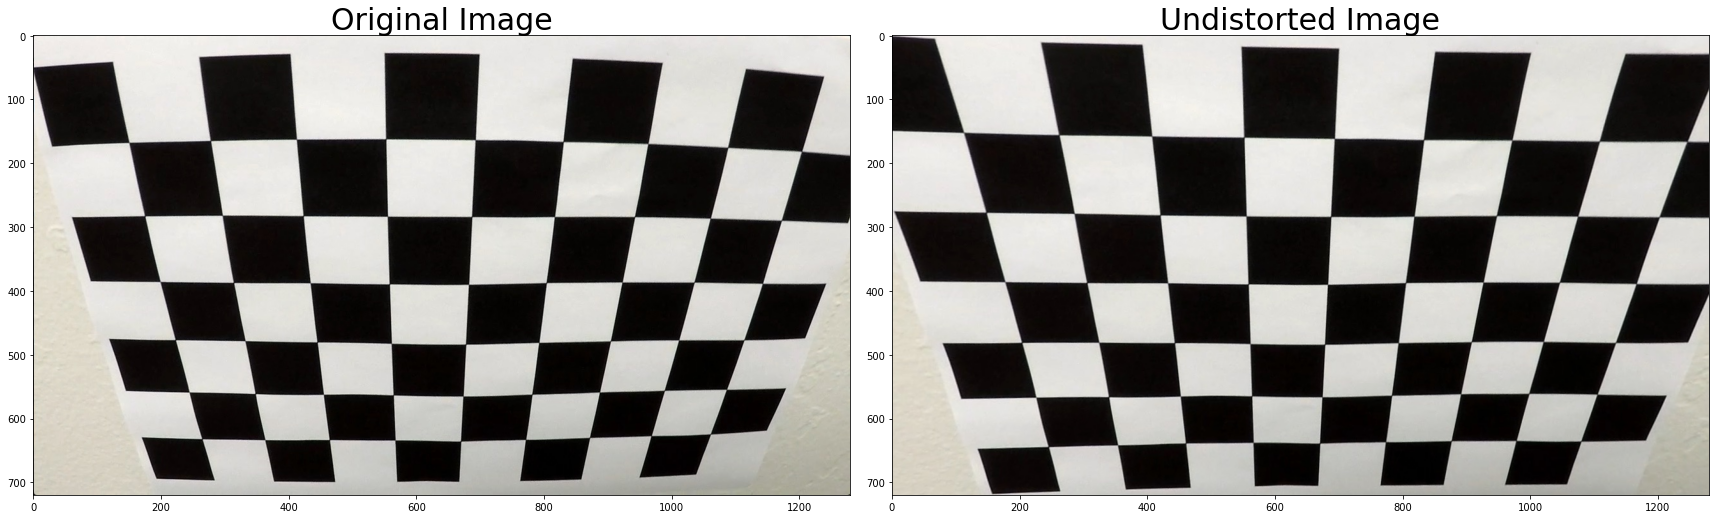

In [3]:
# Test undistortion on an image
img = mpimg.imread(r'camera_cal\calibration2.jpg')

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)

# Undistort a test image
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Save the camera calibration result for later use
dist_pickle = {}
dist_pickle['mtx'] = mtx
dist_pickle['dist'] = dist
pickle.dump(dist_pickle, open('wide_dist_pickle.p', 'wb'))

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
plt.savefig(r'output_images\calibration.jpg')

### 1.3. Apply distortion correction to raw images

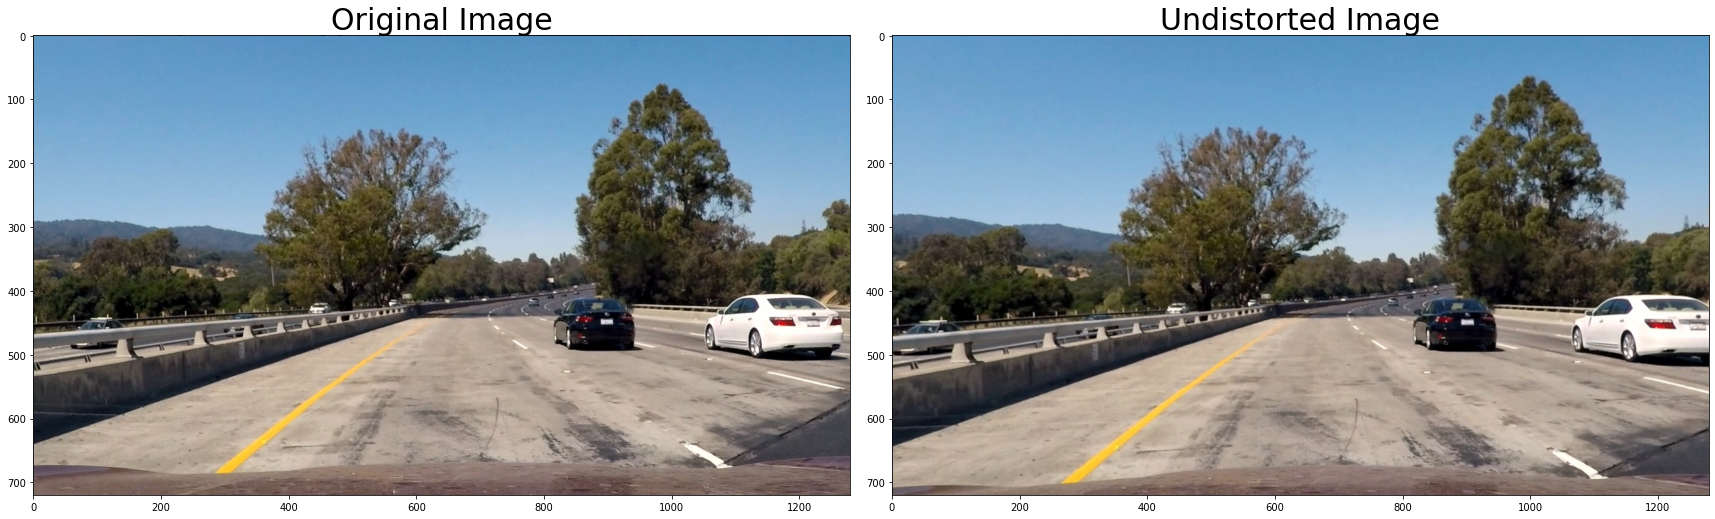

In [4]:
# Apply distortion correction to a raw image
img = mpimg.imread(r'test_images\test1.jpg')

# Read in the saved camera matrix and distortion coefficients
dist_pickle = pickle.load(open('wide_dist_pickle.p', 'rb'))
mtx = dist_pickle['mtx']
dist = dist_pickle['dist']

# Undistort a raw image
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
plt.savefig(r'output_images\distortion.jpg')

## 2. Create a thresholded binary image

### 2.1. Define functions to compute gradients and color transformations 

In [5]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    if orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Take the absolute value of the output from cv2.Sobel()
    abs_sobel = np.absolute(sobel)
    
    # Scale the result to an 8-bit range (0-255)
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    
    # Apply lower and upper thresholds
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    # Create grad_binary
    return grad_binary

def hls_channel_thresh(img, channel='s', thresh=(0, 255)):
    # Convert image to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    
    # Select HLS channel
    if channel == 'h':
        sel_channel = H
    if channel == 'l':
        sel_channel = L
    if channel == 's':
        sel_channel = S
    
    # Threshold selected channel
    channel_binary = np.zeros_like(sel_channel)
    channel_binary[(sel_channel >= thresh[0]) & (sel_channel <= thresh[1])] = 1
    
    # Create channel_binary
    return channel_binary

def combine_thresh(img):
    # Threshold x-axis gradient
    grad_binary = abs_sobel_thresh(img, orient='x', thresh=(20, 100))
    
    # Threshold saturation channel
    sat_binary = hls_channel_thresh(img, channel='s', thresh=(90, 255))
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(grad_binary)
    combined_binary[(grad_binary == 1) | (sat_binary == 1)] = 1
    
    # Create combined binary
    return combined_binary

### 2.2. Test `combine_thresh` with a single raw image

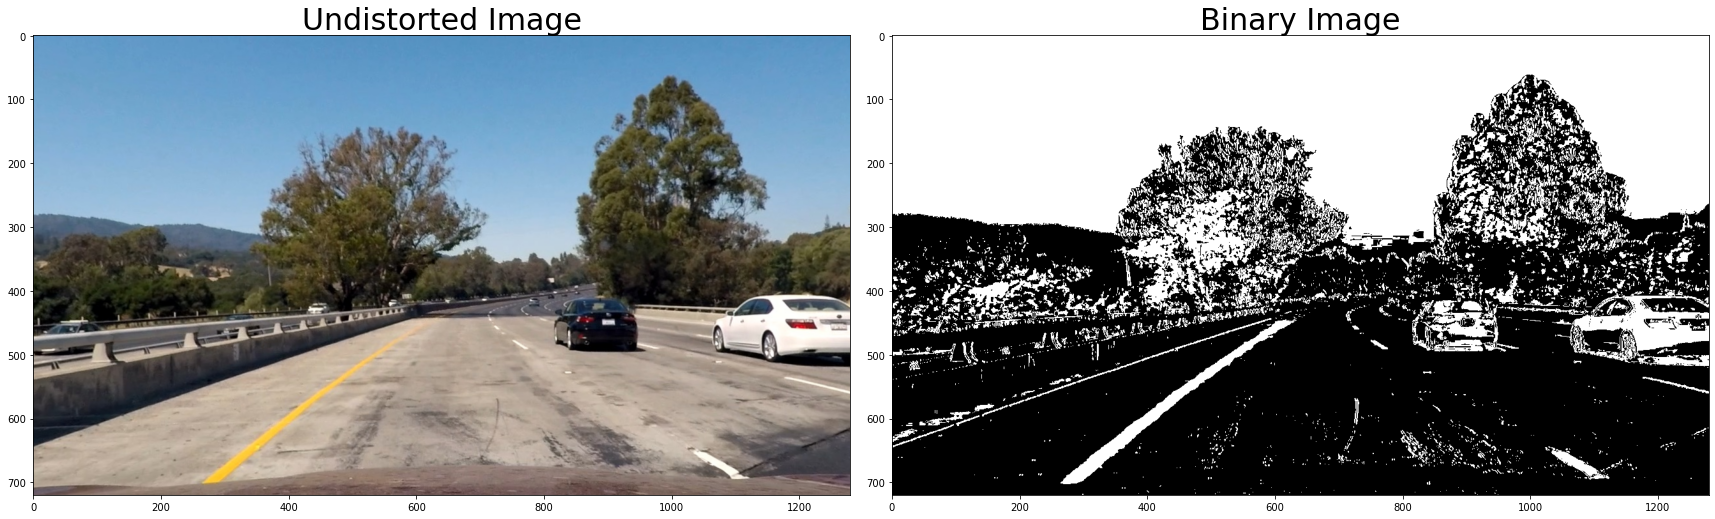

In [6]:
# Read in the saved camera matrix and distortion coefficients
dist_pickle = pickle.load(open('wide_dist_pickle.p', 'rb'))
mtx = dist_pickle['mtx']
dist = dist_pickle['dist']

# Apply distortion correction to a raw image
img = mpimg.imread(r'test_images\test1.jpg')

# Undistort a raw image
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Create a thresholded binary image
binary_image = combine_thresh(dst)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(dst)
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(binary_image, cmap='gray')
ax2.set_title('Binary Image', fontsize=30)
plt.savefig(r'output_images\binary.jpg')

### 2.3. Test `combine_thresh` with all test images

In [ ]:
def batch_undistort(path, keyword):
    # Make a list of test images
    images = glob.glob(os.path.join(path, keyword))

    # Create a plot to visualize undistorted and binary images
    f, ax = plt.subplots(len(images), 2, figsize=(24, 9*len(images)))
    
    # Step through the list
    for i, fname in enumerate(images):
        
        # Apply distortion correction to a raw image
        img = mpimg.imread(fname)
        
        # Undistort a raw image
        dst = cv2.undistort(img, mtx, dist, None, mtx)
        
        # Create a thresholded binary image
        binary_image = combine_thresh(dst)
        
        # Get name of the original image
        shortname = os.path.splitext(os.path.split(fname)[1])[0].capitalize()
        
        # Visualize
        ax[i][0].imshow(dst)
        ax[i][0].set_title('Undistorted {}'.format(shortname), fontsize=30)
        ax[i][1].imshow(binary_image, cmap='gray')
        ax[i][1].set_title('Binary {}'.format(shortname), fontsize=30)

batch_undistort('test_images', 'test*.jpg')

## 3. Apply a perspective transform to rectify binary images

### 3.1. Compute a perspective transform using images with straight lane lines

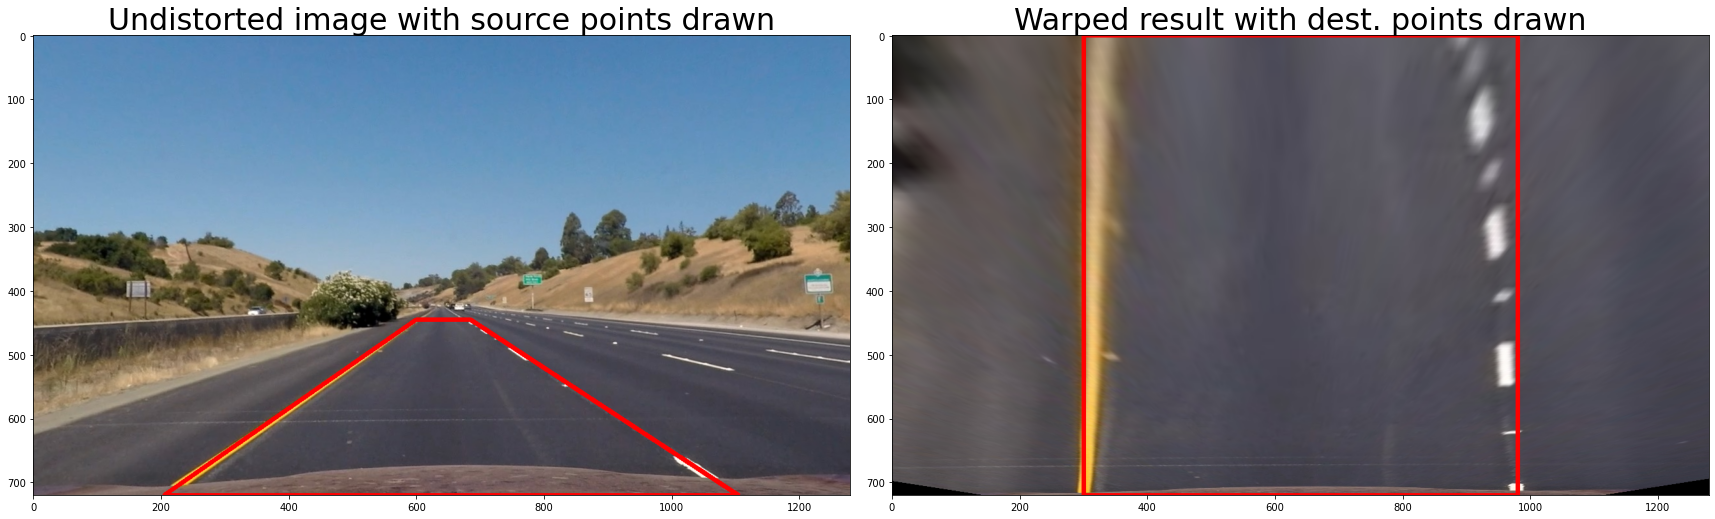

In [7]:
# Read in the saved camera matrix and distortion coefficients
dist_pickle = pickle.load(open('wide_dist_pickle.p', 'rb'))
mtx = dist_pickle['mtx']
dist = dist_pickle['dist']

# Apply distortion correction to image with straight lane lines
img = mpimg.imread(r'test_images\straight_lines1.jpg')
img_size = (img.shape[1], img.shape[0])

# Undistort image
undist = cv2.undistort(img, mtx, dist, None, mtx)

# Four source coordinates
src = np.array([[205, 720], 
                [600, 445], 
                [685, 445], 
                [1105, 720]], dtype=np.float32)

# Reduce the width of the image by offset to form a rectangle
offset = 300

# Four destination coordinates
dst = np.array([[offset, img.shape[0]], 
                [offset, 0], 
                [img.shape[1] - offset, 0], 
                [img.shape[1] - offset, img.shape[0]]], dtype=np.float32)

# Compute the perspective transform, M, given source and destination points
M = cv2.getPerspectiveTransform(src, dst)

# Compute the inverse perspective transform
Minv = cv2.getPerspectiveTransform(dst, src)

# Save the perspective transform result for later use
pers_pickle = {}
pers_pickle['M'] = M
pers_pickle['Minv'] = Minv
pickle.dump(pers_pickle, open('pers_pickle.p', 'wb'))

# Warp an image using the perspective transform, M:
warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)

# Draw source and destination points over images
undist = cv2.polylines(undist, [src.astype(np.int32)], True, (255, 0, 0), thickness=5)
warped = cv2.polylines(warped, [dst.astype(np.int32)], True, (255, 0, 0), thickness=5)

# Visualize perspective transform
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist)
ax1.set_title('Undistorted image with source points drawn', fontsize=30)
ax2.imshow(warped)
ax2.set_title('Warped result with dest. points drawn', fontsize=30)
plt.savefig(r'output_images\perspective.jpg')

### 3.2. Apply a perspective transform to images with curved lines

In [ ]:
# Read in the saved camera matrix and distortion coefficients
dist_pickle = pickle.load(open('wide_dist_pickle.p', 'rb'))
mtx = dist_pickle['mtx']
dist = dist_pickle['dist']

# Read in the saved perspective transform matrices
pers_pickle = pickle.load(open('pers_pickle.p', 'rb'))
M = pers_pickle['M']
Minv = pers_pickle['Minv']

# Apply distortion correction to image with straight lane lines
img = mpimg.imread(r'test_images\test3.jpg')
img_size = (img.shape[1], img.shape[0])

# Undistort image
undist = cv2.undistort(img, mtx, dist, None, mtx)

# Create a thresholded binary image
binary_image = combine_thresh(undist)
undist = np.dstack((binary_image, binary_image, binary_image))*255

# Warp an image using the perspective transform, M:
warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)

# Draw source and destination points over images
undist = cv2.polylines(undist, [src.astype(np.int32)], True, (255, 0, 0), thickness=5)
warped = cv2.polylines(warped, [dst.astype(np.int32)], True, (255, 0, 0), thickness=5)

# Visualize perspective transform
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist, cmap='gray')
ax1.set_title('Undistorted image with source points drawn', fontsize=30)
ax2.imshow(warped, cmap='gray')
ax2.set_title('Warped result with dest. points drawn', fontsize=30)

## 4. Finding the lines

### 4.1. Define functions to implement sliding windows and fit a polynomial

In [8]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Hyperparameters
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Indentify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        
        win_xleft_low   = leftx_current - margin
        win_xleft_high  = leftx_current + margin
        win_xright_low  = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2)
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2)
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ( (nonzeroy >= win_y_low)     & 
                           (nonzeroy <  win_y_high)    & 
                           (nonzerox >= win_xleft_low) & 
                           (nonzerox <  win_xleft_high)).nonzero()[0]
        
        good_right_inds = ( (nonzeroy >= win_y_low)      & 
                            (nonzeroy <  win_y_high)     & 
                            (nonzerox >= win_xright_low) & 
                            (nonzerox <  win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If the number of pixels found > minpix pixels, recenter next window
        # ('rightx_current' or 'leftx_current') on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx  = nonzerox[left_lane_inds]
    lefty  = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using 'np.polyfit'
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if 'left' and 'right_fit' are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    # Visualization
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img

### 4.2. Apply `find_lane_pixels` and `fit_polynomial` to an image with curved lines

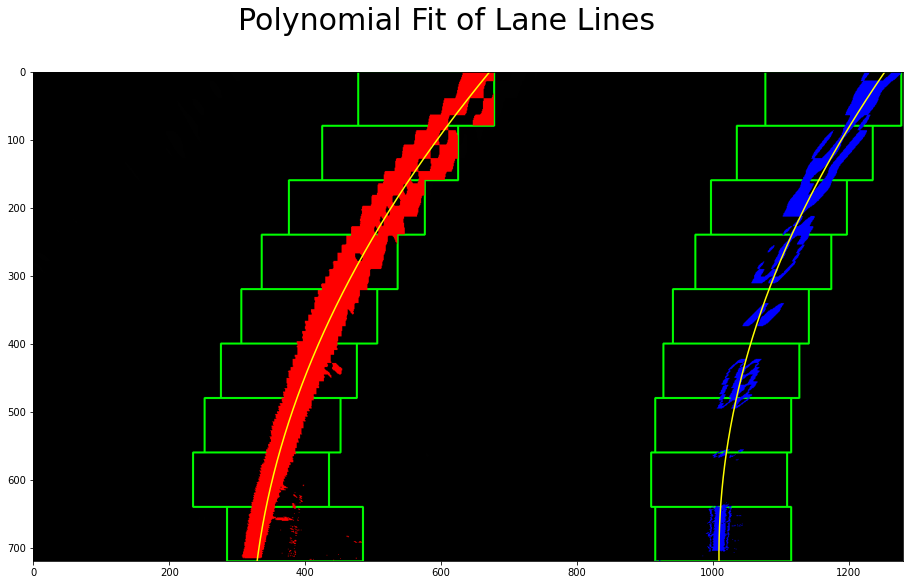

In [17]:
# Read in the saved camera matrix and distortion coefficients
dist_pickle = pickle.load(open('wide_dist_pickle.p', 'rb'))
mtx = dist_pickle['mtx']
dist = dist_pickle['dist']

# Read in the saved perspective transform matrices
pers_pickle = pickle.load(open('pers_pickle.p', 'rb'))
M = pers_pickle['M']
Minv = pers_pickle['Minv']

# Apply distortion correction to image with straight lane lines
img = mpimg.imread(r'test_images\test3.jpg')
img_size = (img.shape[1], img.shape[0])

# Undistort image
undist = cv2.undistort(img, mtx, dist, None, mtx)

# Create a thresholded binary image
thresh = combine_thresh(undist)

# Warp an image using the perspective transform, M:
warped = cv2.warpPerspective(thresh, M, img_size, flags=cv2.INTER_LINEAR)

# Implements sliding windows and fits a polynomial
fig = plt.figure(figsize=(24, 9))
fig.suptitle('Polynomial Fit of Lane Lines', fontsize=30)
out_img = fit_polynomial(warped)
plt.imshow(out_img)
plt.savefig(r'output_images\polynomial.jpg')

### 4.3. Define more convenient versions of the `find_lane_pixels` and `fit_polynomial` functions

In [18]:
def apply_sliding_windows(binary_warped, nwindows=9, margin=100, minpix=50):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Find the peak of the left and right halves of the histogram
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Indentify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        
        win_xleft_low   = leftx_current - margin
        win_xleft_high  = leftx_current + margin
        win_xright_low  = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ( (nonzeroy >= win_y_low)     & 
                           (nonzeroy <  win_y_high)    & 
                           (nonzerox >= win_xleft_low) & 
                           (nonzerox <  win_xleft_high)).nonzero()[0]
        
        good_right_inds = ( (nonzeroy >= win_y_low)      & 
                            (nonzeroy <  win_y_high)     & 
                            (nonzerox >= win_xright_low) & 
                            (nonzerox <  win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If the number of pixels found > minpix pixels, recenter next window
        # ('rightx_current' or 'leftx_current') on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx  = nonzerox[left_lane_inds]
    lefty  = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty

def get_lines_as_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty = apply_sliding_windows(binary_warped)

    # Fit a second order polynomial to each using 'np.polyfit'
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if 'left' and 'right_fit' are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    return ploty, left_fitx, right_fitx

## 5. Determine the curvature of the lane and vehicle position

In [19]:
def measure_curvature_real(ploty, leftx, rightx):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit a second order polynomial to real world positions in each lane lines
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Implement the calculation of radius of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.abs(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.abs(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

def measure_position_real(img_size, ploty, leftx, rightx):
    '''
    Calculates the distance from the center position in meters.
    '''
    # Determine the dimension of the image
    y_max = img_size[0]
    x_max = img_size[1]
    
    # Define conversions in x and y from pixels space to meters
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit a second order polynomial to pixel positions in each lane lines
    left_fit  = np.polyfit(ploty, leftx, 2)
    right_fit = np.polyfit(ploty, rightx, 2)
    
    leftx_pos  = left_fit[0]*y_max**2 + left_fit[1]*y_max + left_fit[2]
    rightx_pos = right_fit[0]*y_max**2 + right_fit[1]*y_max + right_fit[2]
    
    lanex_center = (leftx_pos + rightx_pos)//2
    
    result = ((x_max // 2) - lanex_center) * xm_per_pix
    
    return result

def project_measurements(image, binary_warped, Minv):
    
    ploty, left_fitx, right_fitx = get_lines_as_polynomial(binary_warped)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    
    # Combine the result with the original image
    out_image = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    # Calculate the curvature of polynomial functions in meters
    left_curverad, right_curverad = measure_curvature_real(ploty, left_fitx, right_fitx)
    
    # Calculate the mean and draw the radius of curvature on the image
    curvature = int(np.mean([left_curverad, right_curverad]))
    cv2.putText(out_image, 'Radius of Curvature = {:4d}(m)'.format(curvature), (40, 70), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1.6, (255, 255, 255), 2, cv2.LINE_AA)
    
    # Calculate the vehicle position relative to center
    position = measure_position_real(out_image.shape, ploty, left_fitx, right_fitx)
    
    # Draw the vehicle position on the image
    side = 'left' if position < 0 else 'right'
    cv2.putText(out_image, 'Vehicle is {:.2f}(m) {} of center'.format(abs(position), side), (40, 110), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1.6, (255, 255, 255), 2, cv2.LINE_AA)
    
    return out_image

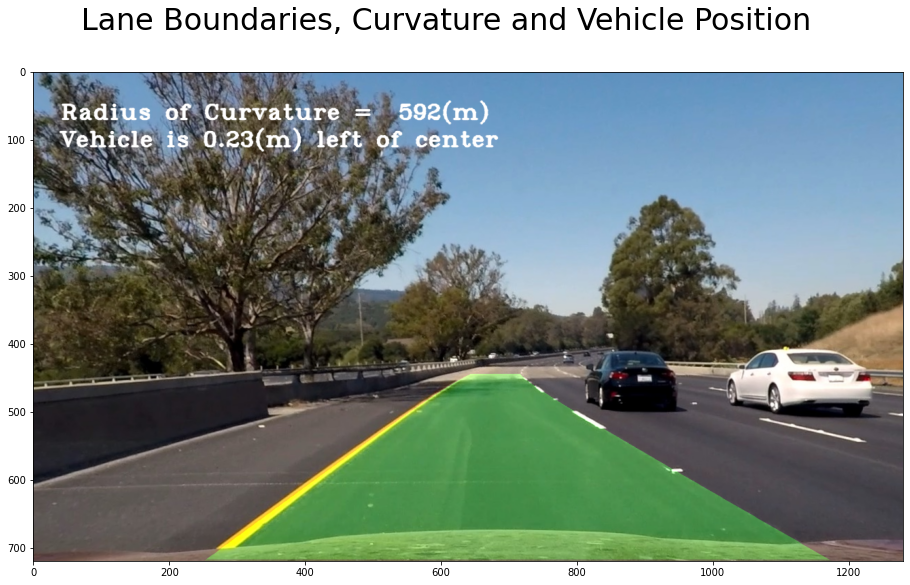

In [21]:
# Read in the saved camera matrix and distortion coefficients
dist_pickle = pickle.load(open('wide_dist_pickle.p', 'rb'))
mtx = dist_pickle['mtx']
dist = dist_pickle['dist']

# Read in the saved perspective transform matrices
pers_pickle = pickle.load(open('pers_pickle.p', 'rb'))
M = pers_pickle['M']
Minv = pers_pickle['Minv']

# Apply distortion correction to raw image
img = mpimg.imread(r'test_images\test6.jpg')
img_size = (img.shape[1], img.shape[0])

# Undistort image
undist = cv2.undistort(img, mtx, dist, None, mtx)

# Create a thresholded binary image
thresh = combine_thresh(undist)

# Warp an image using the perspective transform, M:
warped = cv2.warpPerspective(thresh, M, img_size, flags=cv2.INTER_LINEAR)

# Project the lane boundaries, curvature and vehicle position onto the undistorted image
out_img = project_measurements(undist, warped, Minv)

fig = plt.figure(figsize=(24, 9))
fig.suptitle('Lane Boundaries, Curvature and Vehicle Position', fontsize=30)
plt.imshow(out_img)
plt.savefig(r'output_images\projection.jpg')

## Test Pipeline in the Project Video

In [22]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [23]:
# Read in the saved camera matrix and distortion coefficients
dist_pickle = pickle.load(open('wide_dist_pickle.p', 'rb'))
mtx = dist_pickle['mtx']
dist = dist_pickle['dist']

# Read in the saved perspective transform matrices
pers_pickle = pickle.load(open('pers_pickle.p', 'rb'))
M = pers_pickle['M']
Minv = pers_pickle['Minv']

In [24]:
def process_image(img):
    # Determine the size of the image
    img_size = (img.shape[1], img.shape[0])
    
    # Undistort image
    undist = cv2.undistort(img, mtx, dist, None, mtx)

    # Create a thresholded binary image
    thresh = combine_thresh(undist)

    # Warp an image using the perspective transform, M:
    warped = cv2.warpPerspective(thresh, M, img_size, flags=cv2.INTER_LINEAR)

    # Project the lane boundaries, curvature and vehicle position onto the undistorted image
    out_img = project_measurements(undist, warped, Minv)
    
    return out_img

In [25]:
video_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time output_clip.write_videofile(video_output, audio=False)

t:   0%|                                                                                                                                                                                                 | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video project_video_output.mp4.
Moviepy - Writing video project_video_output.mp4



Moviepy - Done !
Moviepy - video ready project_video_output.mp4
Wall time: 2min 8s


In [26]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))